<a href="https://colab.research.google.com/github/Turemo-Bedho/demo-practice/blob/main/cubeSat_imageClassifactionUsingClassical_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The CubeSat Image Classificaton notebook for Group_8(ByteForce)**

Note: Before running this code be sure you have installed all the required compatible libraries

Loading The Dataset

In [ ]:
import numpy as np

# Load the datasets
train_images = np.load('data/train_images.npy')
train_labels = np.load('data/train_labels.npy')
val_images = np.load('data/val_images.npy')
val_labels = np.load('data/val_labels.npy')
test_images = np.load('data/test_images.npy')
test_labels = np.load('data/test_labels.npy')

# Print basic information about each dataset
print(f"Training images: {train_images.shape}, Training labels: {train_labels.shape}")
print(f"Validation images: {val_images.shape}, Validation labels: {val_labels.shape}")
print(f"Testing images: {test_images.shape}, Testing labels: {test_labels.shape}")

Class Balance Check

In [ ]:
# Check the balance of the classes in each dataset
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

train_class_counts = np.bincount(train_labels)
val_class_counts = np.bincount(val_labels)
test_class_counts = np.bincount(test_labels)

# Display the class distribution with class names
print("\nClass distribution:")
print(f"Training set: {dict(zip(class_names, train_class_counts))}")
print(f"Validation set: {dict(zip(class_names, val_class_counts))}")
print(f"Testing set: {dict(zip(class_names, test_class_counts))}")


Class distribution:
Training set: {'Blurry': 2149, 'Corrupt': 635, 'Missing_Data': 1186, 'Noisy': 2140, 'Priority': 3601}
Validation set: {'Blurry': 727, 'Corrupt': 222, 'Missing_Data': 421, 'Noisy': 721, 'Priority': 1146}
Testing set: {'Blurry': 668, 'Corrupt': 213, 'Missing_Data': 414, 'Noisy': 721, 'Priority': 1221}


Class imbalance check with help of histogram

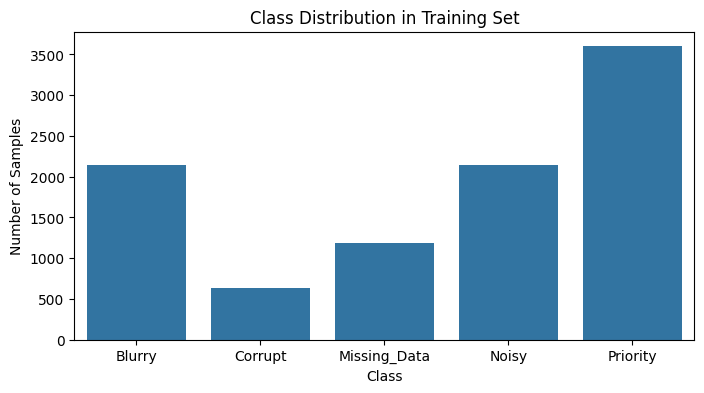

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]
# Count the number of samples in each class
class_counts = np.bincount(train_labels)

# Plot the class distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=class_names, y=class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

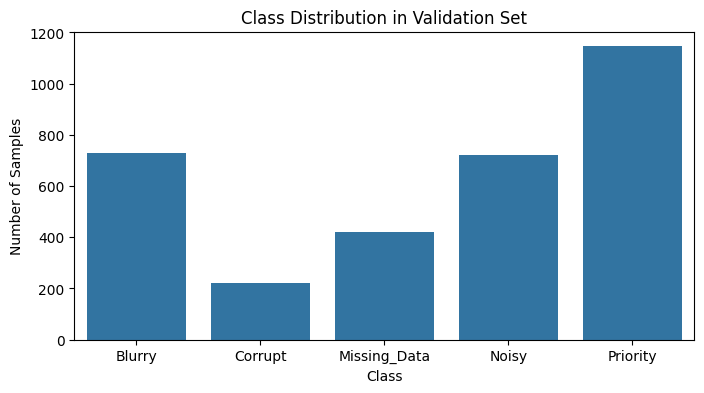

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]
# Count the number of samples in each class
class_counts = np.bincount(val_labels)

# Plot the class distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=class_names, y=class_counts)
plt.title('Class Distribution in Validation Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

# **Preprocesssing** and Feature **Extraction**

In [ ]:
import numpy as np
import cv2
from skimage.feature import hog, local_binary_pattern
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# Define the preprocessing function
def preprocess_image(image, target_size=(128, 128)):
    """
    Preprocess a single image:
    - Convert to grayscale.
    - Resize to target_size.
    - Normalize pixel values to [0, 1].
    """
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    image = cv2.resize(image, target_size)  # Resize to target_size
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Define the feature extraction function
def extract_features(image):
    """
    Extract features from a single image:
    - Quantiles of pixel intensities.
    - Edge detection features (Sobel magnitude, Laplacian variance).
    - HOG features.
    - LBP features.
    - Blur metric (variance of Laplacian).
    """
    # Quantile features
    quantiles = np.quantile(image, [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0])

    # Sobel edge detection
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2).mean()

    # Laplacian variance (blur metric)
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()

    # HOG features
    hog_features = hog(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)

    # LBP features
    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 10), range=(0, 9))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize histogram

    # Combine all features
    features = np.hstack([quantiles, [sobel_magnitude, laplacian_var], hog_features, lbp_hist])
    return features

# Preprocess and extract features for all images in parallel
def preprocess_and_extract_features(images):
    """
    Preprocess and extract features for a batch of images in parallel.
    """
    preprocessed_images = [preprocess_image(img) for img in images]
    features = Parallel(n_jobs=-1)(delayed(extract_features)(img) for img in tqdm(preprocessed_images))
    return np.array(features)

In [ ]:
# Preprocess and extract features for all datasets
train_features = preprocess_and_extract_features(train_images)
val_features = preprocess_and_extract_features(val_images)
test_features = preprocess_and_extract_features(test_images)

100%|██████████| 3237/3237 [00:26<00:00, 123.39it/s]


**Displaying some of Extracted Features**

Displaying feature distributions...
Skipping Feature 1 for Class Missing_Data (zero variance).
Skipping Feature 1 for Class Priority (zero variance).
Skipping Feature 2 for Class Missing_Data (zero variance).


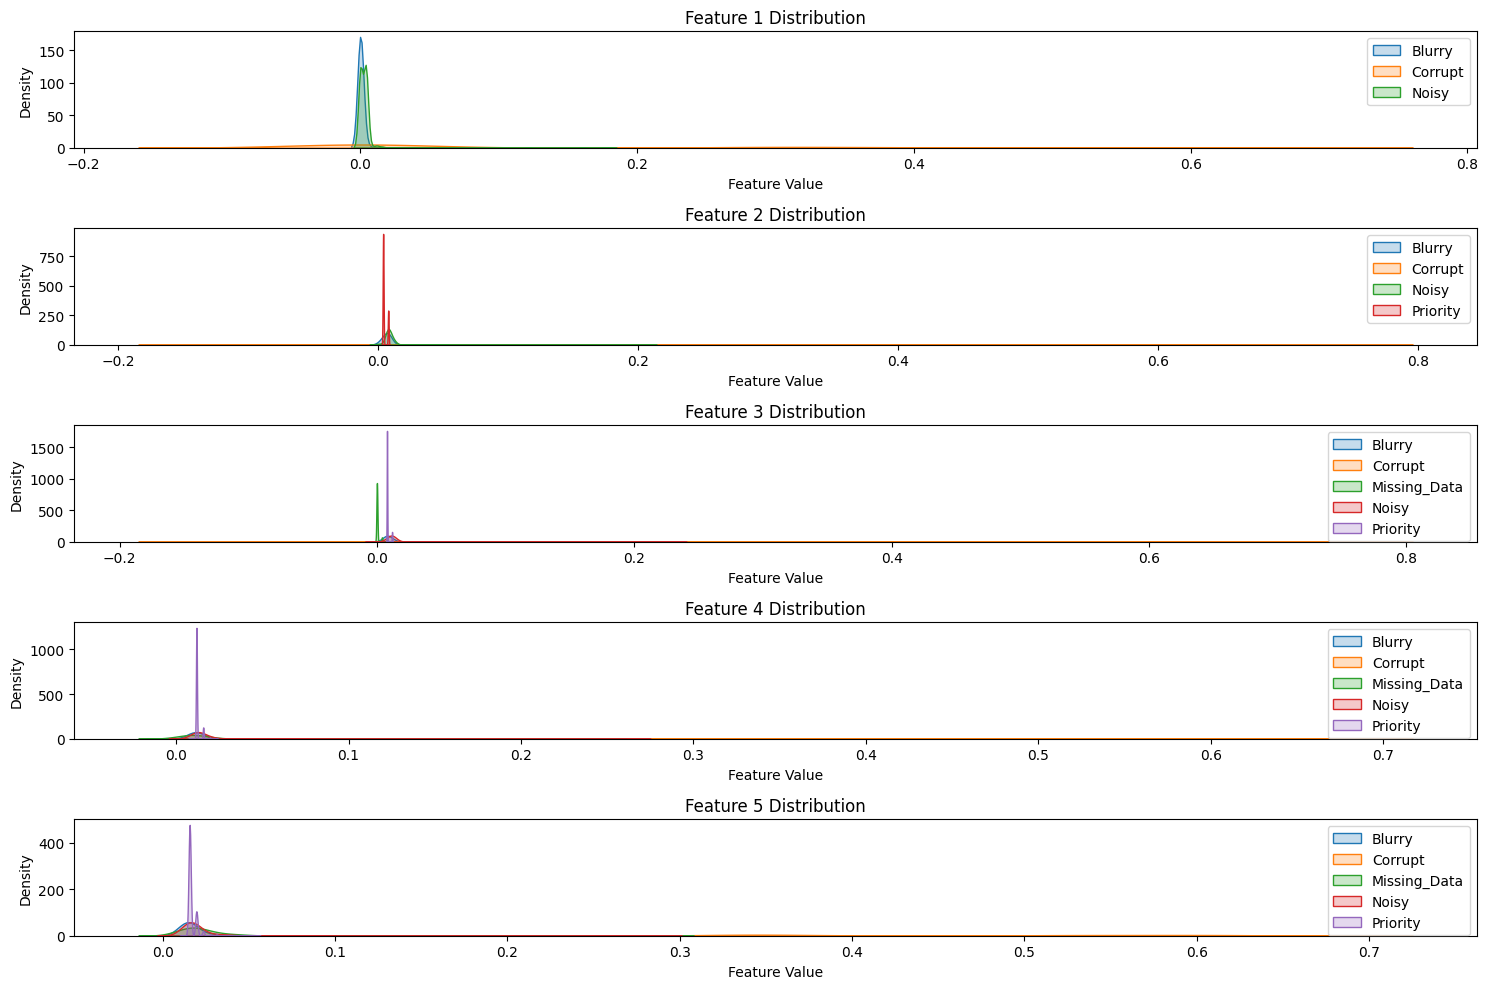

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_feature_distributions(features, labels, class_names, num_features=5):
    """
    Display the distribution of a few extracted features for each class.

    Args:
        features (np.array): Array of extracted features.
        labels (np.array): Array of corresponding labels.
        class_names (list): List of class names.
        num_features (int): Number of features to display.
    """
    plt.figure(figsize=(15, 10))
    for feature_idx in range(num_features):
        plt.subplot(num_features, 1, feature_idx + 1)
        for class_idx, class_name in enumerate(class_names):
            # Extract the current feature for the current class
            class_feature_values = features[labels == class_idx, feature_idx]
            # Skip features with zero variance
            if np.var(class_feature_values) == 0:
                print(f"Skipping Feature {feature_idx + 1} for Class {class_name} (zero variance).")
                continue
            # Plot the feature distribution
            sns.kdeplot(class_feature_values, label=class_name, fill=True, warn_singular=False)
        plt.title(f"Feature {feature_idx + 1} Distribution")
        plt.xlabel("Feature Value")
        plt.ylabel("Density")
        plt.legend()
    plt.tight_layout()
    plt.show()

# Display feature distributions
print("Displaying feature distributions...")
display_feature_distributions(train_features, train_labels, class_names, num_features=5)

# **Memory Management**

In [ ]:
import gc

# Remove the data from memory
del train_images, val_images

# Force garbage collection to free up memory
gc.collect()

# Clear the input/output cache
print("Data removed from memory.")

Data removed from memory.


**Apply Class balance ,Hyperparameter tuning and Trianing The Model**

In [ ]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
train_features_resampled, train_labels_resampled = smote.fit_resample(train_features, train_labels)

# Define class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Define a pipeline with feature selection, scaling, and Logistic Regression
pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=50)),  # Select top 50 features
    ('scaler', StandardScaler()),  # Scale features
    ('pca', PCA(n_components=20)),  # Reduce dimensionality change to 10
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    # 'classifier__C': [0.01, 0.1],
    'classifier__solver': ['liblinear', 'lbfgs'],  # Optimization algorithm
    'classifier__penalty': ['l2'],  # Regularization type
    'classifier__class_weight': ['balanced']
    # 'classifier__class_weight': [{'Blurry': 2, 'Priority': 1}, 'balanced']

    # Adjust class weights
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(train_features_resampled, train_labels_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Perform cross-validation for robust evaluation
cv_scores = cross_val_score(
    best_model,
    train_features_resampled,
    train_labels_resampled,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy',
    n_jobs=-1
)
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Best hyperparameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Cross-validation accuracy: 0.9999 (±0.0001)


**Save The Trained Model**

In [ ]:
import joblib

# Save the model
joblib.dump(best_model, 'myTestimage_classifier_optimized.pkl')

['myTestimage_classifier_optimized.pkl']

In [ ]:
# Load the trained model
best_model = joblib.load('myTestimage_classifier_optimized.pkl')

In [ ]:
import sys
sys.path.append('/home/dsrh82/CubeSat_ImageClassify')  # Add the correct path

from source.evaluate import *  # Import from source


# **Result Of Evaluation of Trained Model**

Evaluate with given evualate Function

/shared/venv/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 3237/3237 [00:24<00:00, 132.66it/s]



### Evaluation Metrics ###

Evaluation Time:       25.05 seconds (The time it took for the pipeline to preprocess data and make predictions.)
Peak Memory Usage:     13494.69 MB (The maximum memory used during evaluation.)
Average CPU Usage:     107.96 % (The % shows how much of one CPU core was used during the evaluation.)
Algorithm code size:         0.04 MB (The size of the trained model and preprocessing function.)
Accuracy:              1.000 (The percentage of correctly classified samples.)
F1 Score:              1.000 (A balance of precision and recall, useful for imbalanced datasets.)

### Confusion Matrix ###



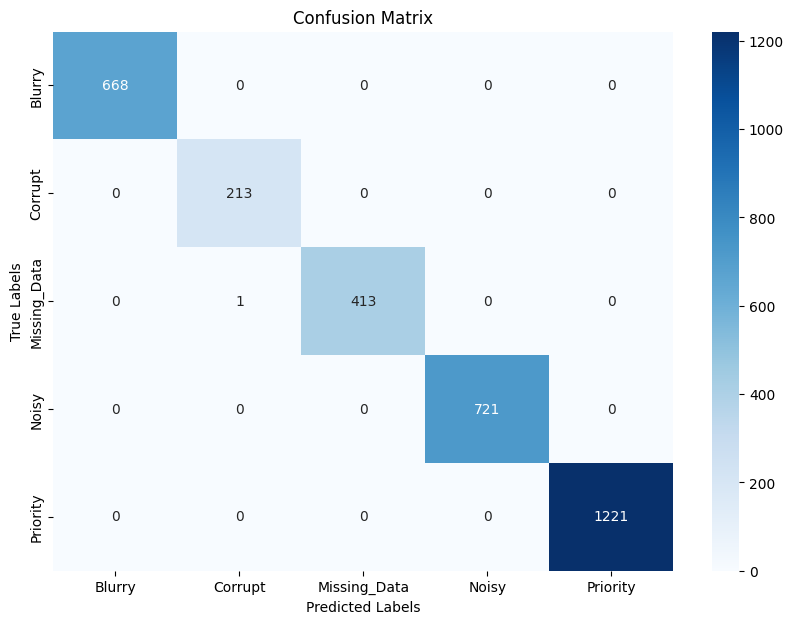

In [ ]:
# Evaluate the pipeline
metrics = evaluate_pipeline(best_model, test_images, test_labels, preprocess_and_extract_features)

More evualtaion using ROC-AUC and Precision-Recall AUC

In [ ]:
# Evaluate on the validation set
val_predictions = best_model.predict(val_features)
val_predict_proba = best_model.predict_proba(val_features)

print("\nValidation Set Classification Report:")
print(classification_report(val_labels, val_predictions, target_names=class_names))

# Binarize the labels for multi-class ROC-AUC and Precision-Recall AUC
val_labels_bin = label_binarize(val_labels, classes=np.unique(val_labels))

# Compute ROC-AUC for each class and average
roc_auc = roc_auc_score(val_labels_bin, val_predict_proba, multi_class='ovr')
print("Validation Set ROC-AUC Score:", roc_auc)

# Compute Precision-Recall AUC for each class and average
pr_auc_scores = []
for i in range(val_labels_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(val_labels_bin[:, i], val_predict_proba[:, i])
    pr_auc_scores.append(auc(recall, precision))
pr_auc = np.mean(pr_auc_scores)
print("Validation Set Precision-Recall AUC:", pr_auc)

# Evaluate on the test set
test_predictions = best_model.predict(test_features)
test_predict_proba = best_model.predict_proba(test_features)

print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

# Binarize the labels for multi-class ROC-AUC and Precision-Recall AUC
test_labels_bin = label_binarize(test_labels, classes=np.unique(test_labels))

# Compute ROC-AUC for each class and average
roc_auc = roc_auc_score(test_labels_bin, test_predict_proba, multi_class='ovr')
print("Test Set ROC-AUC Score:", roc_auc)

# Compute Precision-Recall AUC for each class and average
pr_auc_scores = []
for i in range(test_labels_bin.shape[1]):
    precision, recall, _ = precision_recall_curve(test_labels_bin[:, i], test_predict_proba[:, i])
    pr_auc_scores.append(auc(recall, precision))
pr_auc = np.mean(pr_auc_scores)
print("Test Set Precision-Recall AUC:", pr_auc)


Validation Set Classification Report:
              precision    recall  f1-score   support

      Blurry       1.00      1.00      1.00       727
     Corrupt       1.00      1.00      1.00       222
Missing_Data       1.00      1.00      1.00       421
       Noisy       1.00      1.00      1.00       721
    Priority       1.00      1.00      1.00      1146

    accuracy                           1.00      3237
   macro avg       1.00      1.00      1.00      3237
weighted avg       1.00      1.00      1.00      3237

Validation Set ROC-AUC Score: 1.0
Validation Set Precision-Recall AUC: 1.0

Test Set Classification Report:
              precision    recall  f1-score   support

      Blurry       1.00      1.00      1.00       668
     Corrupt       1.00      1.00      1.00       213
Missing_Data       1.00      1.00      1.00       414
       Noisy       1.00      1.00      1.00       721
    Priority       1.00      1.00      1.00      1221

    accuracy                          

**Learning Curves of training and Validation Datasets**

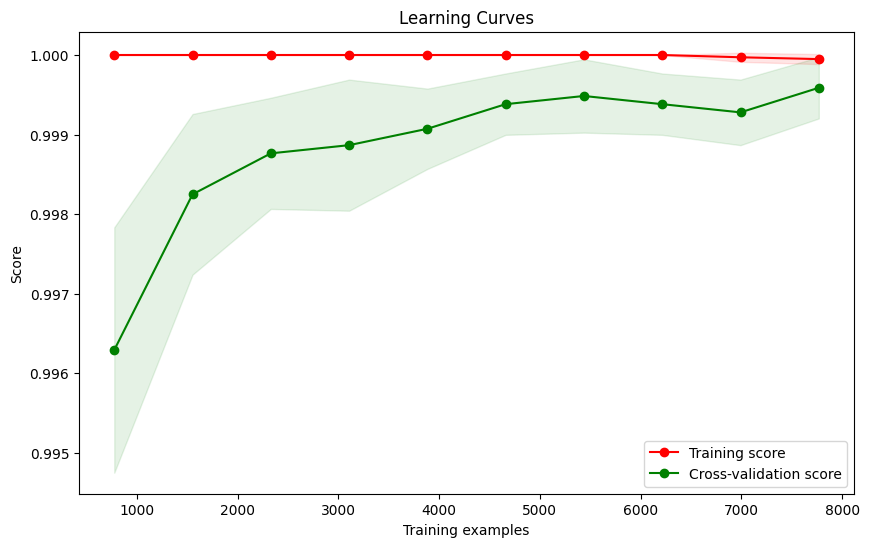

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import joblib  # To load your model

# ... (Load your data and split into train/validation sets)

# Load the trained model
best_model = joblib.load('myTestimage_classifier_optimized.pkl')

# Plot learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    train_features,  # Your training features
    train_labels,  # Your training labels
    cv=5,  # Use cross-validation to get more robust estimates
    scoring='accuracy',  # Or 'f1_macro' if classes are imbalanced
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10) # Vary the training size
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.show()

Show the misclassified images

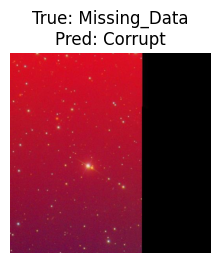

In [ ]:
# Plot a few misclassified images to understand why the model is confusing certain classes:
import matplotlib.pyplot as plt

def show_misclassified(images, labels, predictions, class_names, num_images=5):
    misclassified_indices = np.where(labels != predictions)[0]
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(misclassified_indices[:num_images]):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[idx])
        plt.title(f"True: {class_names[labels[idx]]}\nPred: {class_names[predictions[idx]]}")
        plt.axis('off')
    plt.show()

show_misclassified(test_images, test_labels, best_model.predict(test_features), class_names)

**Show the first 30 images That are correctly classified by the trained model**

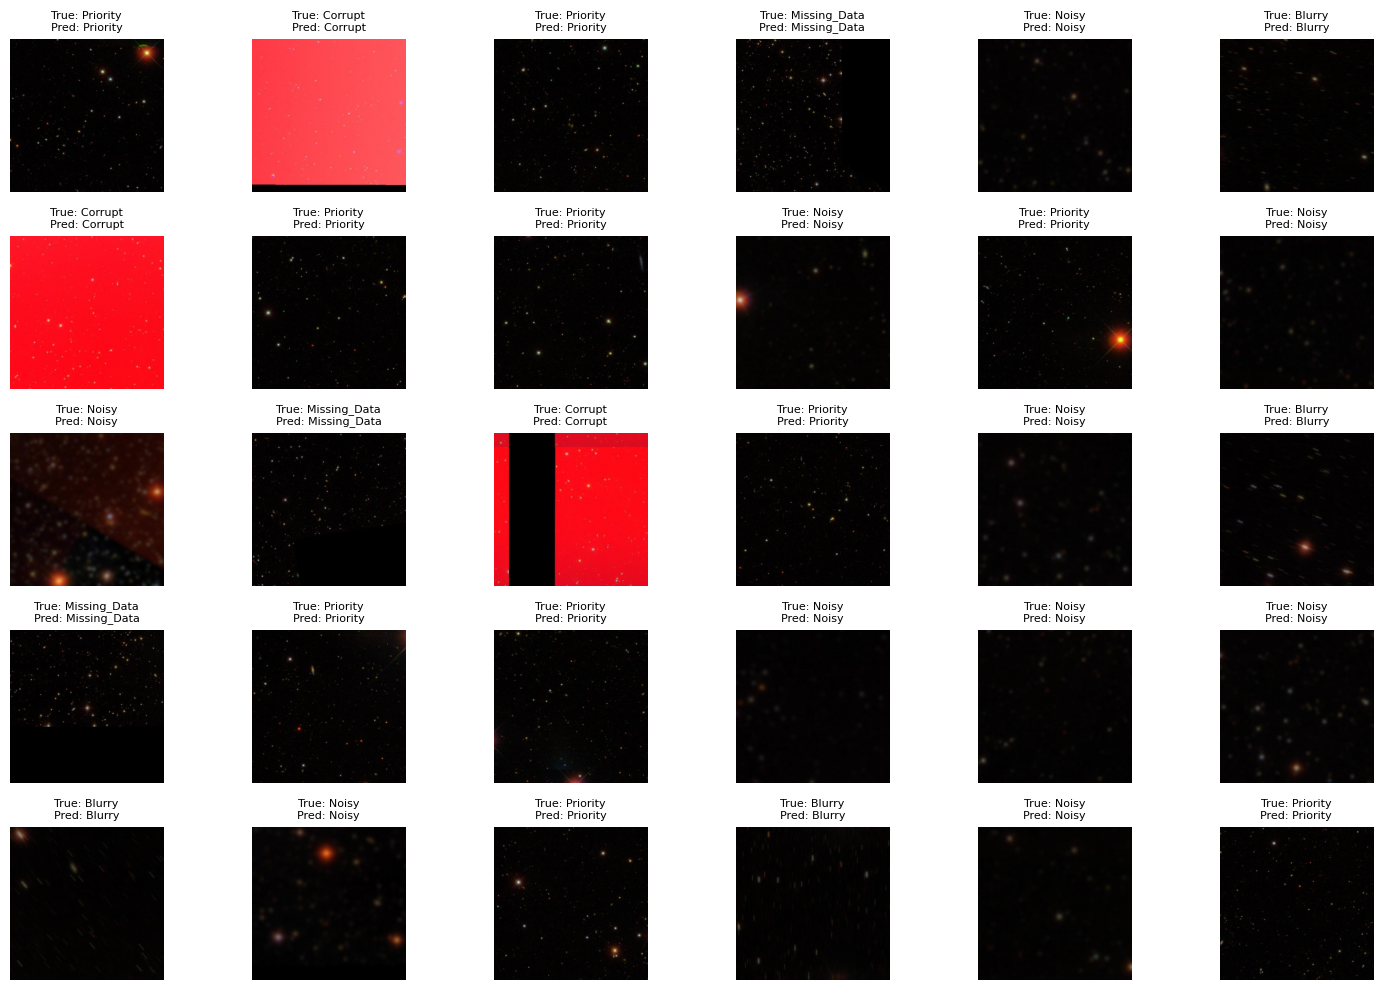

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_correctly_classified(images, labels, predictions, class_names, num_images=30):
    # Get indices of correctly classified images
    correctly_classified_indices = np.where(labels == predictions)[0]

    # Set up the plot
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(correctly_classified_indices[:num_images]):
        plt.subplot(5, 6, i + 1)  # 5 rows, 6 columns grid
        plt.imshow(images[idx], cmap='gray' if images[idx].ndim == 2 else None)  # Handle grayscale images
        plt.title(f"True: {class_names[labels[idx]]}\nPred: {class_names[predictions[idx]]}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
show_correctly_classified(test_images, test_labels, best_model.predict(test_features), class_names)

# **Qauntizing the Trainied Model**

**Step 1: Convert original model to ONNX format**



In [ ]:
import pickle
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Load your trained model
# with open("myTestimage_classifier_optimized.pkl", "rb") as f:
#     model = pickle.load(f)


best_model = joblib.load('myTestimage_classifier_optimized.pkl')

number_of_features = 50  # Replace this with the correct number

# Define the initial type for the ONNX model
initial_type = [('float_input', FloatTensorType([None, number_of_features]))]

# Convert the model to ONNX format
onnx_model = convert_sklearn(best_model, initial_types=initial_type)

# Save the ONNX model
with open("original_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

**Step 2: Quantize the ONNX model**

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

# Quantize the model
quantized_model = quantize_dynamic(
    "original_model.onnx",  # Input ONNX model
    "model_quantized.onnx",  # Output quantized ONNX model
    weight_type=QuantType.QUInt8  # Quantization type (e.g., UInt8)
)

print("Model quantized and saved as 'model_quantized.onnx'")
